# Net Radiation

In [28]:
import numpy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [110]:
def read_site_csv(csv_filename):
    csv_data = numpy.genfromtxt(csv_filename, delimiter=',', dtype=str)
    csv_v = csv_data[:, 1]
    csv_v = csv_v.astype(float)
    return csv_data[:, 0], csv_v


def mapping_comparison_single(site_obs, site_cal, fig_title='', axis_min=-200, axis_max=900):
    plt.figure(figsize=(8,8))
    
    nan_indices = numpy.isnan(site_obs) | numpy.isnan(site_cal)

    # 删除包含 NaN 值的位置
    x = site_obs[~nan_indices]
    y = site_cal[~nan_indices]
    
    # 绘制1:1参考线
    x_11 = numpy.arange(axis_min, axis_max + 1)
    y_11 = 1 * x_11
    plt.plot(x_11, y_11, color='k', linewidth=1, linestyle='--',)

    # 使用线性回归模型拟合数据
    model = LinearRegression()
    x = x.reshape(-1, 1)
    model.fit(x, y)
    y_pred = model.predict(x)
    xx = numpy.arange(axis_min, axis_max + 0.1, 0.05)
    yy_pred = model.coef_[0] * xx + model.intercept_
    
    # 绘制密度散点图
    xy = numpy.vstack([x.flatten(), y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x_, y_, z = x[idx], y[idx], z[idx]
    z = (z-numpy.min(z))/(numpy.max(z)-numpy.min(z))*100
    plt.scatter(x_, y_, marker='o', c=z, s=8, cmap='turbo')
    
    # 绘制散点图和回归线
#     plt.scatter(x, y, color='b')
    plt.plot(xx, yy_pred, color='red')
    

    # 添加标签
    plt.title(fig_title)
    plt.xlabel('Net radiation observed at site (W/m²)')
    plt.ylabel('Net radiation calculated for ET (W/m²)')
    
    # 计算散点个数
    num = numpy.count_nonzero(~numpy.isnan(x))

    # 计算回归方程
    equation = f'y = {model.coef_[0]:.2f} * x + {model.intercept_:.2f}'

    # 计算评估指标
    r2 = r2_score(y, y_pred)
    rmse = numpy.sqrt(mean_squared_error(y, y_pred))
    bias = numpy.mean(y_pred - y)
    mae = mean_absolute_error(y, y_pred)

    print('N:', num)
    print('R²:', r2)
    print('RMSE:', rmse)
    print('Bias:', bias)
    print('MAE', mae)

    plt.annotate(f'N: {num:d}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)
    plt.annotate(equation, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'R²: {r2:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.80), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'Bias: {bias:.2f}', xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'MAE: {mae:.2f}', xy=(0.05, 0.70), xycoords='axes fraction', fontsize=10)

    # 显示图形
    plt.xlim((axis_min, axis_max))
    plt.ylim((axis_min, axis_max))
#     plt.colorbar(label='density')
    plt.show()

    
def show_r_net_curve_week(site_name, week_idx, site_obs, site_cal, save_flag=0):
    # 30-min
    # good 30
    #     week_idx = 30

    week_obs_10min = site_obs[7*24*6*week_idx:7*24*6*(week_idx+1)]
    week_obs_hh = week_obs_10min[::3]

    week_cal_10min = site_cal[7*24*6*week_idx:7*24*6*(week_idx+1)]
    week_cal_hh = numpy.mean(week_cal_10min.reshape(-1, 3), axis=1)

    week_timelist_10min = obs_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
    # week_timelist_hh = week_timelist_10min[::3]

    formatted_dates = []
    for date_string in week_timelist_10min:
        dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
        formatted_date = dt_object.strftime("%-H:%M")
        formatted_dates.append(formatted_date)

    plt.figure(figsize=(18, 4))
    plt.plot(numpy.linspace(0, len(week_obs_hh), len(week_obs_hh)), week_obs_hh, '-', color='black', label='EC-site observed net radiation')
    plt.plot(numpy.linspace(0, len(week_cal_hh), len(week_cal_hh)), week_cal_hh, '-', color='red', label='Input net radiation for ET estimation')
    plt.plot(numpy.linspace(0, len(week_cal_hh), len(week_cal_hh)), week_cal_hh, '.', color='red')
    plt.xticks(numpy.linspace(0, len(week_obs_hh), int(len(week_obs_hh)/6)), formatted_dates[::18], rotation=45, ha='right')
    plt.ylabel(r'$W/m^2$', fontsize=14)
    plt.xlim(0,len(week_obs_hh))
    plt.ylim((-100,950))
    title_str = site_name + ' ' + (week_timelist_10min[0] + ' - ' + week_timelist_10min[-1]).replace('T',' ').replace('Z','')
    plt.title(title_str)
    plt.legend()
    if save_flag:
        plt.savefig(storage_folder + '/Rnet ' + title_str + '.png', dpi=300)
    else:
        plt.show()

In [104]:
storage_folder = '/disk2/workspace/20231122'

## CRK

N: 19661
R²: 0.9442849817763771
RMSE: 54.64360634128081
Bias: -1.401642310346357e-14
MAE 35.34085186183383


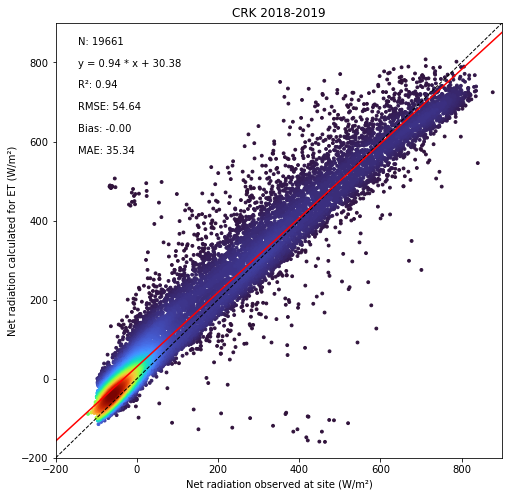

In [105]:
SITE_OBS_CSV = '/disk2/Data/FluxSite4ET/validation/CRK_2018_2019_Rnet.csv'
obs_timelist, site_obs = read_site_csv(SITE_OBS_CSV)
SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/CRK_RnetV002.csv'
cal_timelist, site_cal = read_site_csv(SITE_CAL_CSV)

mapping_comparison_single(site_obs, site_cal, 'CRK 2018-2019')

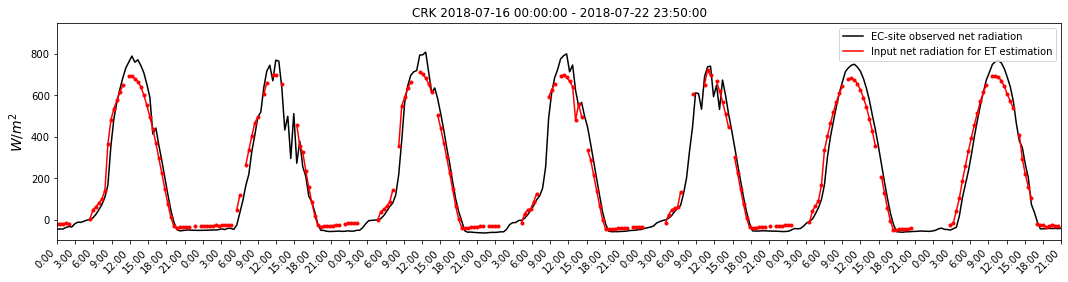

In [111]:
show_r_net_curve_week('CRK', 28, site_obs, site_cal, 1)

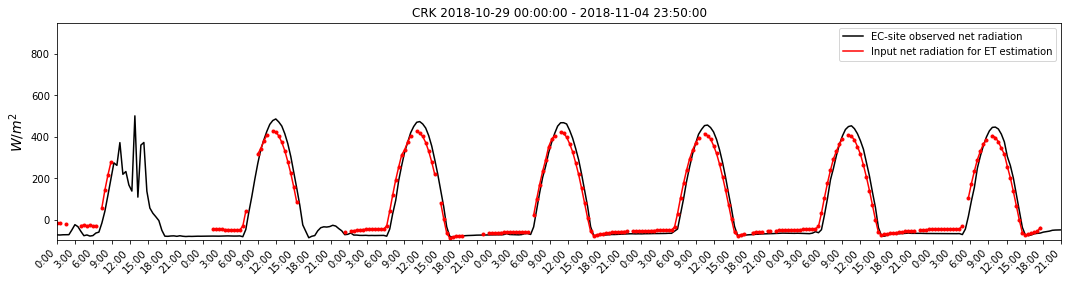

In [112]:
show_r_net_curve_week('CRK', 43, site_obs, site_cal, 1)

## GCK

N: 19448
R²: 0.9365386094416418
RMSE: 59.20428012300799
Bias: 7.295412046306912e-15
MAE 36.46586588470134


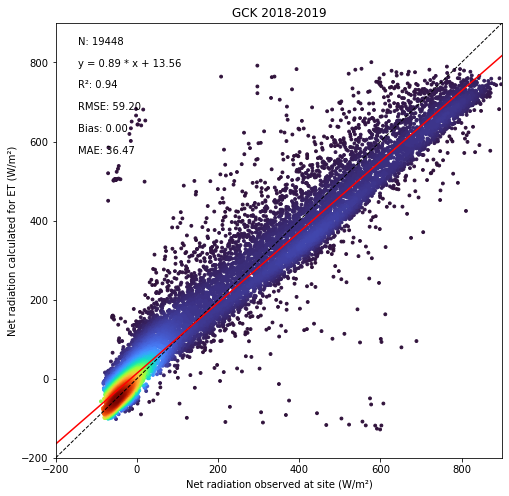

In [99]:
SITE_OBS_CSV = '/disk2/Data/FluxSite4ET/validation/GCK_2018_2019_Rnet.csv'
obs_timelist, site_obs = read_site_csv(SITE_OBS_CSV)
SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/GCK_RnetV002.csv'
cal_timelist, site_cal = read_site_csv(SITE_CAL_CSV)

mapping_comparison_single(site_obs, site_cal, 'GCK 2018-2019')

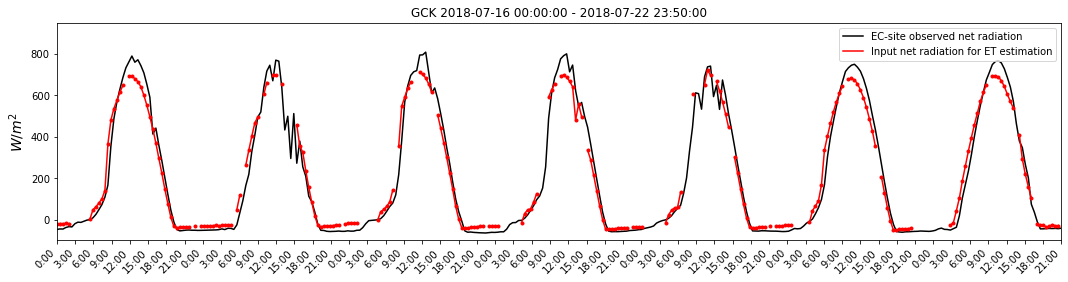

In [113]:
show_r_net_curve_week('GCK', 28, site_obs, site_cal, 1)

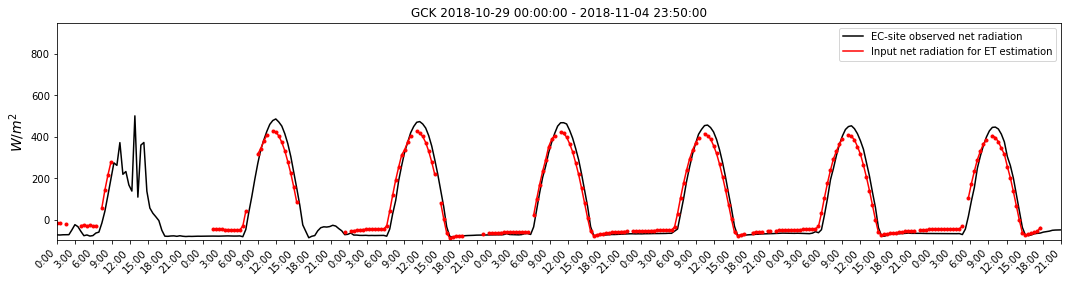

In [114]:
show_r_net_curve_week('GCK', 43, site_obs, site_cal, 1)

## GDK

N: 19309
R²: 0.9349845597708667
RMSE: 60.301061861145044
Bias: -1.7427781845563388e-14
MAE 37.988987927975174


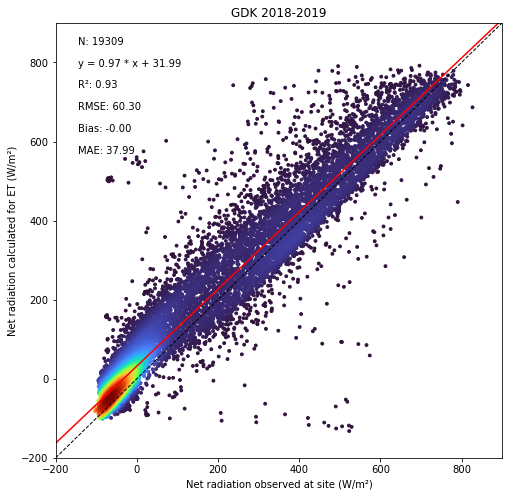

In [115]:
SITE_OBS_CSV = '/disk2/Data/FluxSite4ET/validation/GDK_2018_2019_Rnet.csv'
obs_timelist, site_obs = read_site_csv(SITE_OBS_CSV)
SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/GDK_RnetV002.csv'
cal_timelist, site_cal = read_site_csv(SITE_CAL_CSV)

mapping_comparison_single(site_obs, site_cal, 'GDK 2018-2019')

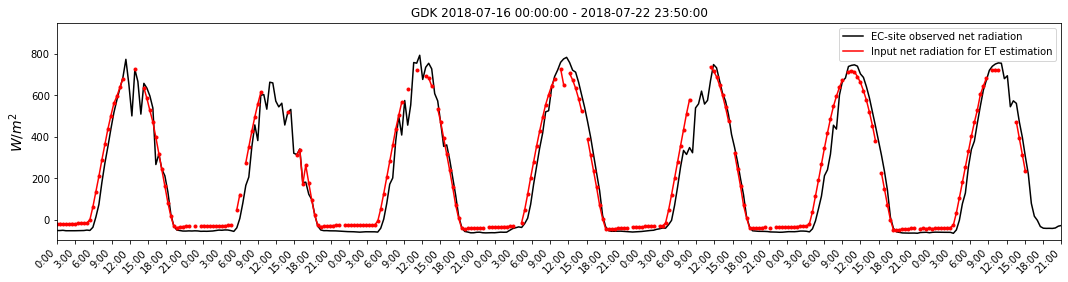

In [116]:
show_r_net_curve_week('GDK', 28, site_obs, site_cal, 1)

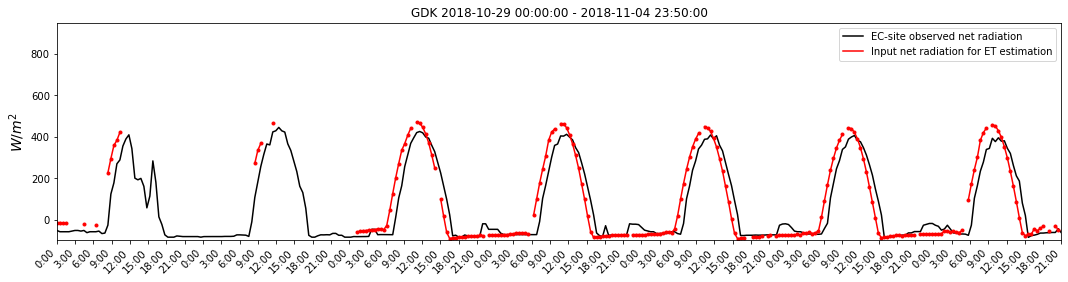

In [117]:
show_r_net_curve_week('GDK', 43, site_obs, site_cal, 1)

## TKY

N: 7388
R²: 0.8996692544555474
RMSE: 75.26391190042281
Bias: 2.954503633263438e-15
MAE 46.85809366498511


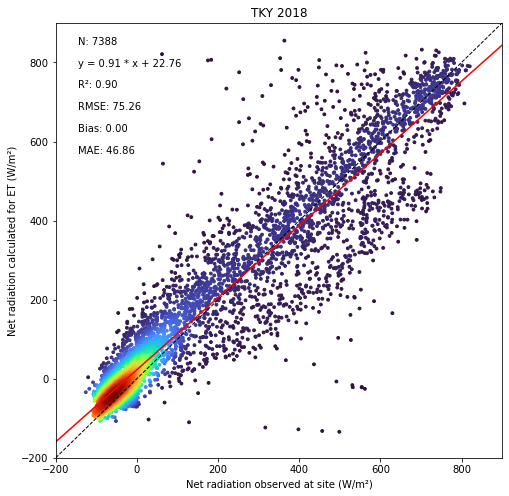

In [23]:
SITE_OBS_CSV = '/disk2/Data/FluxSite4ET/validation/TKY_2018_2019_Rnet.csv'
obs_timelist, site_obs = read_site_csv(SITE_OBS_CSV)
SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/TKY_RnetV002.csv'
cal_timelist, site_cal = read_site_csv(SITE_CAL_CSV)

mapping_comparison_single(site_obs, site_cal, 'TKY 2018')

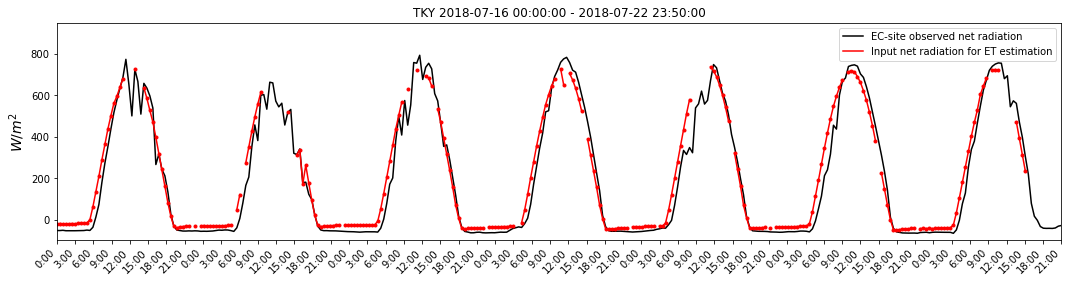

In [118]:
show_r_net_curve_week('TKY', 28, site_obs, site_cal, 1)

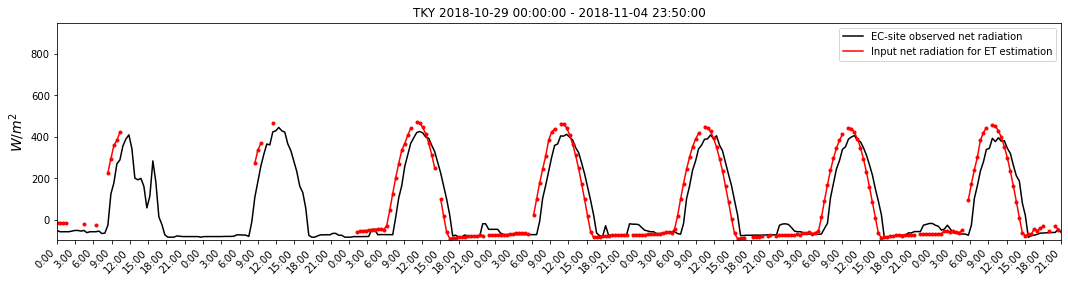

In [119]:
show_r_net_curve_week('TKY', 43, site_obs, site_cal, 1)

# Part Radiation

In [11]:
import numpy
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [167]:
def read_site_csv(csv_filename):
    csv_data = numpy.genfromtxt(csv_filename, delimiter=',', dtype=str)
    csv_v = csv_data[:, 1]
    csv_v = csv_v.astype(float)
    return csv_data[:, 0], csv_v


def half_hour_to_10min_by_nan(arr_half_hour):
    new_len = 3 * len(arr_half_hour)
    arr_10min = numpy.full(new_len, numpy.nan)
    arr_10min[::3] = arr_half_hour
    return arr_10min


def mapping_comparison(site_obs, site_cal, fig_title='', axis_min=-200, axis_max=900):
    
    data_labels = ['Rsd', 'Rsu', 'Rld', 'Rlu']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    axis_min_max = [[0, 1200], [0, 600], [0, 600], [0, 600]]
    
    nan_indices = numpy.isnan(site_obs[0])\
    |numpy.isnan(site_obs[1])\
    |numpy.isnan(site_obs[2])\
    |numpy.isnan(site_obs[3])\
    |numpy.isnan(site_cal[0])\
    |numpy.isnan(site_cal[1])\
    |numpy.isnan(site_cal[2])\
    |numpy.isnan(site_cal[3])
    
    count_idx = 0
    for c_idx in range(2):
        for v_idx in range(2):
            site_obs_item = site_obs[count_idx]
            site_cal_item = site_cal[count_idx]
            axis_min = axis_min_max[count_idx][0]
            axis_max = axis_min_max[count_idx][1]
            # 删除包含 NaN 值的位置
            x = site_obs_item[~nan_indices]
            y = site_cal_item[~nan_indices]

            # 绘制1:1参考线
            x_11 = numpy.arange(axis_min, axis_max + 1)
            y_11 = 1 * x_11
            axes[c_idx, v_idx].plot(x_11, y_11, color='k', linewidth=1, linestyle='--',)

            # 使用线性回归模型拟合数据
            model = LinearRegression()
            x = x.reshape(-1, 1)
            model.fit(x, y)
            y_pred = model.predict(x)
            xx = numpy.arange(axis_min, axis_max + 0.1, 0.05)
            yy_pred = model.coef_[0] * xx + model.intercept_

            # 绘制密度散点图
            xy = numpy.vstack([x.flatten(), y])
            z = gaussian_kde(xy)(xy)
            idx = z.argsort()
            x_, y_, z = x[idx], y[idx], z[idx]
            z = (z-numpy.min(z))/(numpy.max(z)-numpy.min(z))*100
            axes[c_idx, v_idx].scatter(x_, y_, marker='o', c=z, s=8, cmap='turbo')

            # 绘制散点图和回归线
            axes[c_idx, v_idx].plot(xx, yy_pred, color='red')


            # 添加标签
            axes[c_idx, v_idx].set_xlabel(data_labels[count_idx] + ' radiation observed at site (W/m²)')
            axes[c_idx, v_idx].set_ylabel(data_labels[count_idx] + ' radiation calculated for ET (W/m²)')

            # 计算散点个数
            num = numpy.count_nonzero(~numpy.isnan(x))

            # 计算回归方程
            equation = f'y = {model.coef_[0]:.2f} * x + {model.intercept_:.2f}'

            # 计算评估指标
            r2 = r2_score(y, y_pred)
            rmse = numpy.sqrt(mean_squared_error(y, y_pred))
            bias = numpy.mean(y_pred - y)
            mae = mean_absolute_error(y, y_pred)

            print('N:', num)
            print('R²:', r2)
            print('RMSE:', rmse)
            print('Bias:', bias)
            print('MAE', mae)

            axes[c_idx, v_idx].annotate(f'N: {num:d}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(equation, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(f'R²: {r2:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.80), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(f'Bias: {bias:.2f}', xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(f'MAE: {mae:.2f}', xy=(0.05, 0.70), xycoords='axes fraction', fontsize=10)

            # 显示图形
            axes[c_idx, v_idx].set_xlim((axis_min, axis_max))
            axes[c_idx, v_idx].set_ylim((axis_min, axis_max))
            
            count_idx = count_idx + 1
        
    plt.suptitle(fig_title)
    plt.show()

    
def show_radiation_curve_week(site_name, week_idx, site_obs_list, site_cal_list, save_flag=0):
    fig, axes = plt.subplots(len(site_names), 1, figsize=(16, 4 * len(site_names)))
    r_labels = ['Rsd', 'Rsu', 'Rld', 'Rlu']
    
    for i in range(len(site_obs_list)):
        site_obs = site_obs_list[i]
        site_cal = site_cal_list[i]
        
        week_obs_10min = site_obs[7*24*6*week_idx:7*24*6*(week_idx+1)]
        week_obs_hh = week_obs_10min[::3]

        week_cal_10min = site_cal[7*24*6*week_idx:7*24*6*(week_idx+1)]
#         week_cal_hh = numpy.mean(week_cal_10min.reshape(-1, 3), axis=1)
        week_cal_hh = week_cal_10min[::3]

        week_timelist_10min = obs_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
        # week_timelist_hh = week_timelist_10min[::3]

        formatted_dates = []
        for date_string in week_timelist_10min:
            dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
            formatted_date = dt_object.strftime("%-H:%M")
            formatted_dates.append(formatted_date)

        axes[i].plot(numpy.linspace(0, len(week_obs_hh), len(week_obs_hh)), week_obs_hh, 
                     '-', color='black', label='EC-site observed '+r_labels[i]+' radiation')
        axes[i].plot(numpy.linspace(0, len(week_cal_hh), len(week_cal_hh)), week_cal_hh, 
                     '-', color='red', label='Input '+r_labels[i]+' radiation for ET estimation')
        axes[i].plot(numpy.linspace(0, len(week_cal_hh), len(week_cal_hh)), week_cal_hh, 
                     '.', color='red')
        
        axes[i].set_ylabel(r'$W/m^2$', fontsize=14)
        axes[i].set_xlim(0,len(week_obs_hh))
#         axes[i].set_ylim((-100,950))
        title_str = site_name + ' ' + (week_timelist_10min[0] + ' - ' + week_timelist_10min[-1]).replace('T',' ').replace('Z','')
        axes[i].set_title(title_str)
        axes[i].legend()
    plt.xticks(numpy.linspace(0, len(week_obs_hh), int(len(week_obs_hh)/6)), formatted_dates[::18], rotation=45, ha='right')
    if save_flag:
        plt.savefig(storage_folder + '/Rnet ' + title_str + '.png', dpi=300)
    else:
        plt.show()

In [215]:
site_name = 'CRK'
data_labels = ['AMATERASS_Rsd', 'Rsu', 'ERA5_Rld_10min', 'RluV002']

SITE_CSV = '/disk2/Data/FluxSite4ET/validation/'+site_name+'_2018_2019_L2.csv'
csv_data = numpy.genfromtxt(SITE_CSV, delimiter=',', dtype=str)
site_obs = [half_hour_to_10min_by_nan(csv_data[:,1][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,2][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,3][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,4][1:].astype(float))]
site_cal = []
for data_label in  data_labels:
    SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/'+site_name+'_'+data_label+'.csv'
    cal_timelist, site_cal_item = read_site_csv(SITE_CAL_CSV)
    site_cal.append(site_cal_item)
    
site_cal[0]=numpy.roll(site_cal[0], 2)
site_cal[1]=numpy.roll(site_cal[1], 2)
site_cal[2]=numpy.roll(site_cal[2], -3)+10
site_cal[3]=numpy.roll(site_cal[3], 3)+10

# mapping_comparison(site_obs, site_cal, site_name + ' 2018-2019')

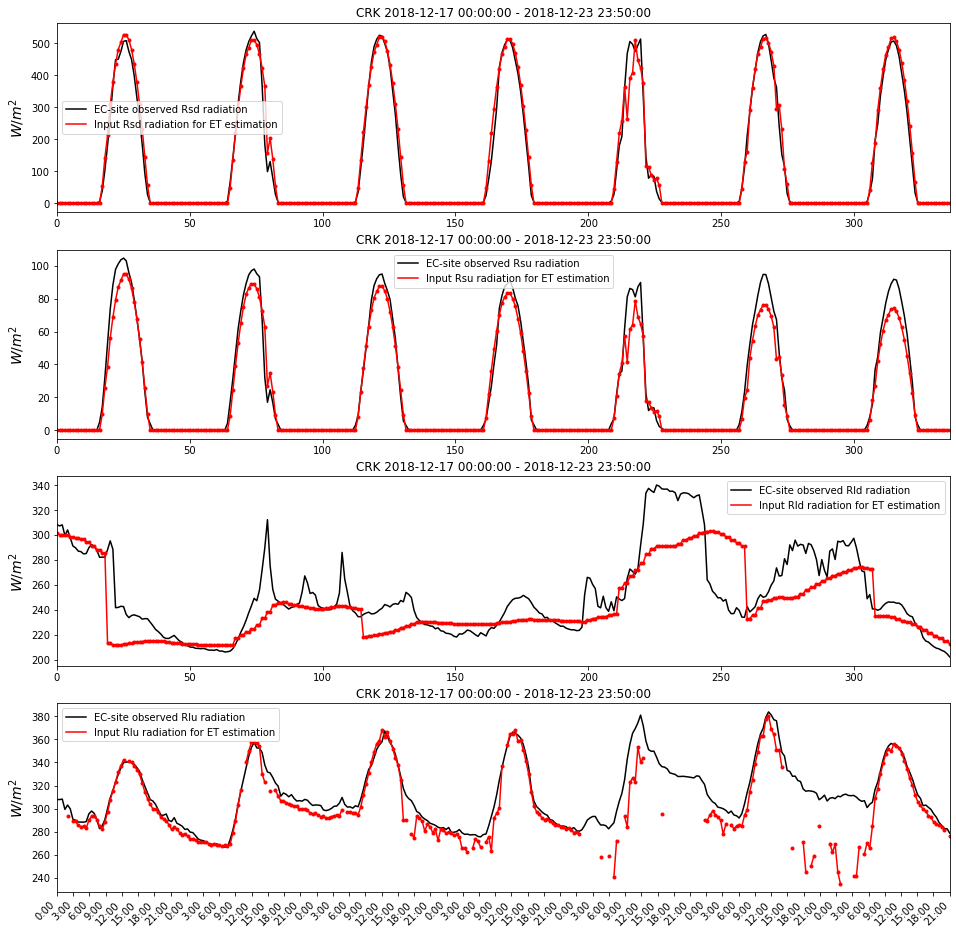

In [216]:
show_radiation_curve_week(site_name, 50, site_obs, site_cal, 0)

N: 19448
R²: 0.9569133383037365
RMSE: 62.012160710190805
Bias: 2.6375720475109603e-14
MAE 31.722894424424236
N: 19448
R²: 0.9061800396900868
RMSE: 12.9547957297816
Bias: 8.745141363201234e-15
MAE 6.769371813360503
N: 19448
R²: 0.8809814195626994
RMSE: 24.91872070749749
Bias: 1.510524417280213e-14
MAE 20.216373757586314
N: 19448
R²: 0.9338378216695783
RMSE: 15.560623482284855
Bias: 4.8729611232383344e-14
MAE 10.93433457337205


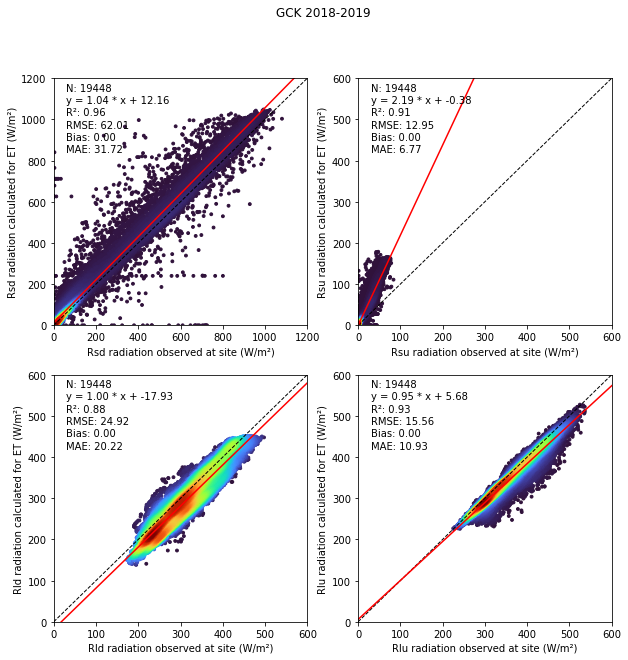

In [15]:
site_name = 'GCK'
data_labels = ['AMATERASS_Rsd', 'Rsu', 'ERA5_Rld_10min', 'RluV002']

SITE_CSV = '/disk2/Data/FluxSite4ET/validation/'+site_name+'_2018_2019_L2.csv'
csv_data = numpy.genfromtxt(SITE_CSV, delimiter=',', dtype=str)
site_obs = [half_hour_to_10min_by_nan(csv_data[:,1][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,2][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,3][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,4][1:].astype(float))]
site_cal = []
for data_label in  data_labels:
    SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/'+site_name+'_'+data_label+'.csv'
    cal_timelist, site_cal_item = read_site_csv(SITE_CAL_CSV)
    site_cal.append(site_cal_item)

mapping_comparison(site_obs, site_cal, site_name + ' 2018-2019')

N: 19309
R²: 0.9548283375346631
RMSE: 63.71823481746526
Bias: -7.536338095378762e-16
MAE 34.47570411254446
N: 19309
R²: 0.9252907115568593
RMSE: 11.674641056909815
Bias: 1.4130633928835179e-15
MAE 6.814168000620334
N: 19309
R²: 0.8964048489667751
RMSE: 23.17459438516019
Bias: -3.367801086372384e-14
MAE 18.279713714868233
N: 19309
R²: 0.9335401548460349
RMSE: 15.370235909880872
Bias: 7.33850922037507e-14
MAE 10.292350272668191


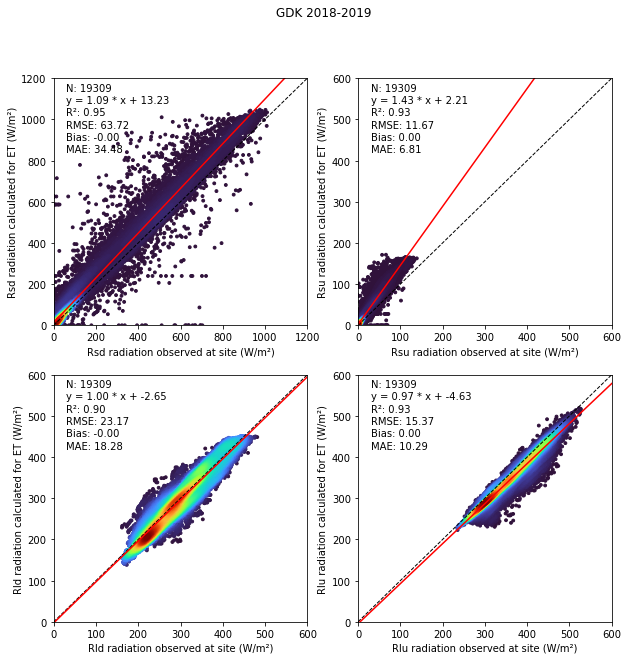

In [16]:
site_name = 'GDK'
data_labels = ['AMATERASS_Rsd', 'Rsu', 'ERA5_Rld_10min', 'RluV002']

SITE_CSV = '/disk2/Data/FluxSite4ET/validation/'+site_name+'_2018_2019_L2.csv'
csv_data = numpy.genfromtxt(SITE_CSV, delimiter=',', dtype=str)
site_obs = [half_hour_to_10min_by_nan(csv_data[:,1][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,2][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,3][1:].astype(float)), 
            half_hour_to_10min_by_nan(csv_data[:,4][1:].astype(float))]
site_cal = []
for data_label in  data_labels:
    SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/'+site_name+'_'+data_label+'.csv'
    cal_timelist, site_cal_item = read_site_csv(SITE_CAL_CSV)
    site_cal.append(site_cal_item)

mapping_comparison(site_obs, site_cal, site_name + ' 2018-2019')

N: 7388
R²: 0.9481500809002842
RMSE: 70.74622482237199
Bias: 1.8958064980107058e-14
MAE 35.51868836878082
N: 7388
R²: 0.7600955037249942
RMSE: 30.676509678385443
Bias: -2.954503633263438e-15
MAE 15.178374037753002
N: 7388
R²: 0.802146774052823
RMSE: 25.344911902001964
Bias: -5.022656176547844e-14
MAE 19.978854819838695
N: 7388
R²: 0.8996705635370994
RMSE: 17.486511752292852
Bias: 5.539694312368946e-16
MAE 12.761749784202326


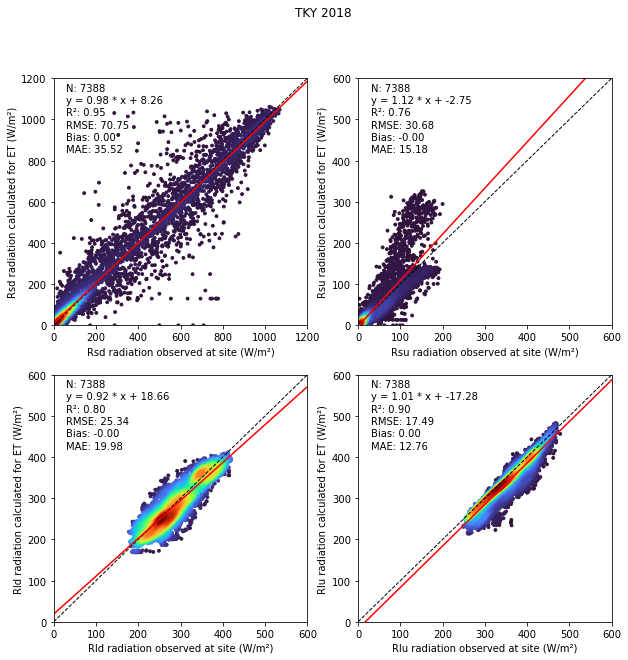

In [17]:
def half_hour_to_10min_by_nan_2y(arr_half_hour):
    new_len = 3 * len(arr_half_hour)
    arr_10min = numpy.full(new_len, numpy.nan)
    arr_10min[::3] = arr_half_hour
    nan_10min = numpy.full(len(arr_10min), numpy.nan)
    arr_10min_2y = numpy.concatenate((arr_10min, nan_10min))
    return arr_10min_2y


site_name = 'TKY'
data_labels = ['AMATERASS_Rsd', 'Rsu', 'ERA5_Rld_10min', 'RluV002']

SITE_CSV = '/disk2/Data/FluxSite4ET/validation/'+site_name+'_2018.csv'
csv_data = numpy.genfromtxt(SITE_CSV, delimiter=',', dtype=str)
site_obs = [half_hour_to_10min_by_nan_2y(csv_data[:,3][1:].astype(float)), 
            half_hour_to_10min_by_nan_2y(csv_data[:,4][1:].astype(float)), 
            half_hour_to_10min_by_nan_2y(csv_data[:,5][1:].astype(float)), 
            half_hour_to_10min_by_nan_2y(csv_data[:,6][1:].astype(float))]
site_cal = []
for data_label in  data_labels:
    SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/'+site_name+'_'+data_label+'.csv'
    cal_timelist, site_cal_item = read_site_csv(SITE_CAL_CSV)
    site_cal.append(site_cal_item)

mapping_comparison(site_obs, site_cal, site_name + ' 2018')

## Rlu update

In [8]:
def read_site_csv(csv_filename):
    csv_data = numpy.genfromtxt(csv_filename, delimiter=',', dtype=str)
    csv_v = csv_data[:, 1]
    csv_v = csv_v.astype(float)
    return csv_data[:, 0], csv_v


def half_hour_to_hour_by_nan_2y(arr_half_hour):
    arr_hour = arr_half_hour[::2]
    nan_hour = numpy.full(len(arr_hour), numpy.nan)
    arr_hour_2y = numpy.concatenate((arr_hour, nan_hour))
    return arr_hour_2y


def half_hour_to_hour(arr_half_hour):
    arr_hour = arr_half_hour[::2]
    return arr_hour


def min10_to_hour(arr_10min):
    arr_hour = arr_10min[::6]
    return arr_hour


def half_hour_to_10min_by_nan(arr_half_hour):
    new_len = 3 * len(arr_half_hour)
    arr_10min = numpy.full(new_len, numpy.nan)
    arr_10min[::3] = arr_half_hour
    return arr_10min


def half_hour_to_10min_by_nan_2y(arr_half_hour):
    new_len = 3 * len(arr_half_hour)
    arr_10min = numpy.full(new_len, numpy.nan)
    arr_10min[::3] = arr_half_hour
    nan_10min = numpy.full(len(arr_10min), numpy.nan)
    arr_10min_2y = numpy.concatenate((arr_10min, nan_10min))
    return arr_10min_2y


def mapping_rlu_comparison(site_obs, site_cal, fig_title='', axis_min=0, axis_max=600):
    
    site_names = ['TKY','CRK', 'GCK', 'GDK']
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    axis_min_max = [[0, 600], [0, 600], [0, 600], [0, 600]]
    
    nan_indices = numpy.isnan(site_obs[0])\
    |numpy.isnan(site_obs[1])\
    |numpy.isnan(site_obs[2])\
    |numpy.isnan(site_obs[3])\
    |numpy.isnan(site_cal[0])\
    |numpy.isnan(site_cal[1])\
    |numpy.isnan(site_cal[2])\
    |numpy.isnan(site_cal[3])
    
    count_idx = 0
    for c_idx in range(2):
        for v_idx in range(2):
            site_obs_item = site_obs[count_idx]
            site_cal_item = site_cal[count_idx]
            axis_min = axis_min_max[count_idx][0]
            axis_max = axis_min_max[count_idx][1]
            # 删除包含 NaN 值的位置
            x = site_obs_item[~nan_indices]
            y = site_cal_item[~nan_indices]

            # 绘制1:1参考线
            x_11 = numpy.arange(axis_min, axis_max + 1)
            y_11 = 1 * x_11
            axes[c_idx, v_idx].plot(x_11, y_11, color='k', linewidth=1, linestyle='--',)

            # 使用线性回归模型拟合数据
            model = LinearRegression()
            x = x.reshape(-1, 1)
            model.fit(x, y)
            y_pred = model.predict(x)
            xx = numpy.arange(axis_min, axis_max + 0.1, 0.05)
            yy_pred = model.coef_[0] * xx + model.intercept_

            # 绘制密度散点图
            xy = numpy.vstack([x.flatten(), y])
            z = gaussian_kde(xy)(xy)
            idx = z.argsort()
            x_, y_, z = x[idx], y[idx], z[idx]
            z = (z-numpy.min(z))/(numpy.max(z)-numpy.min(z))*100
            axes[c_idx, v_idx].scatter(x_, y_, marker='o', c=z, s=8, cmap='turbo')

            # 绘制散点图和回归线
            axes[c_idx, v_idx].plot(xx, yy_pred, color='red')


            # 添加标签
            axes[c_idx, v_idx].set_xlabel('Rlu radiation observed at site (W/m²)')
            axes[c_idx, v_idx].set_ylabel('Rlu radiation calculated for ET (W/m²)')

            # 计算散点个数
            num = numpy.count_nonzero(~numpy.isnan(x))

            # 计算回归方程
            equation = f'y = {model.coef_[0]:.2f} * x + {model.intercept_:.2f}'

            # 计算评估指标
            r2 = r2_score(y, y_pred)
            rmse = numpy.sqrt(mean_squared_error(y, y_pred))
            bias = numpy.mean(y_pred - y)
            mae = mean_absolute_error(y, y_pred)

            print('N:', num)
            print('R²:', r2)
            print('RMSE:', rmse)
            print('Bias:', bias)
            print('MAE', mae)

            axes[c_idx, v_idx].annotate(f'N: {num:d}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(equation, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(f'R²: {r2:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.80), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(f'Bias: {bias:.2f}', xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10)
            axes[c_idx, v_idx].annotate(f'MAE: {mae:.2f}', xy=(0.05, 0.70), xycoords='axes fraction', fontsize=10)

            # 显示图形
            axes[c_idx, v_idx].set_xlim((axis_min, axis_max))
            axes[c_idx, v_idx].set_ylim((axis_min, axis_max))
            axes[c_idx, v_idx].set_title(site_names[count_idx] + ' 2018-2019')
            count_idx = count_idx + 1
        
    plt.suptitle(fig_title)
    plt.show()


N: 3648
R²: 0.9115888694185273
RMSE: 16.72628156480238
Bias: 5.6344792379572855e-14
MAE 12.540856507816795
N: 3648
R²: 0.9572610531428583
RMSE: 14.837101406085626
Bias: 2.2936818136817268e-14
MAE 10.306057344490279
N: 3648
R²: 0.9631506128105687
RMSE: 12.848495635731975
Bias: -5.360234673277949e-14
MAE 9.133108174080673
N: 3648
R²: 0.9629258474431399
RMSE: 12.726356244728152
Bias: 1.0159514555166344e-13
MAE 8.434101775175517


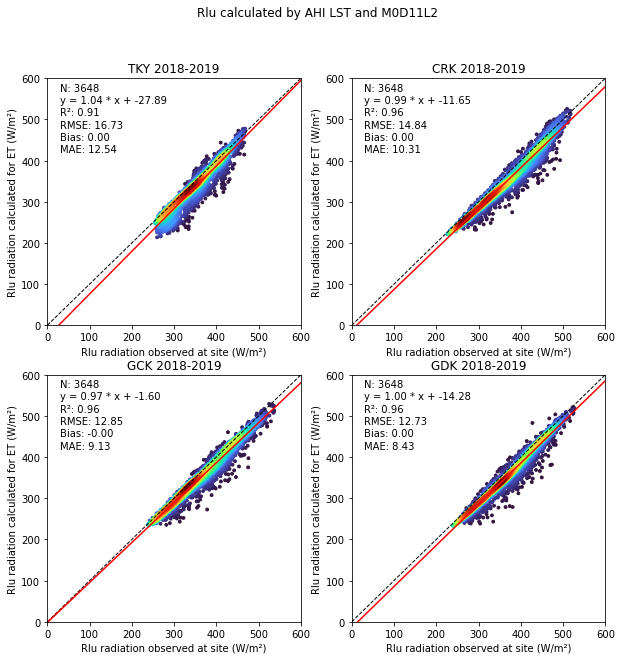

In [9]:
site_names = ['TKY','CRK', 'GCK', 'GDK']

SITE_TKY_CSV = '/disk2/Data/FluxSite4ET/validation/TKY_2018.csv'
tky_csv_data = numpy.genfromtxt(SITE_TKY_CSV, delimiter=',', dtype=str)
tky_site_obs_10min = half_hour_to_10min_by_nan_2y(tky_csv_data[:,6][1:].astype(float))

SITE_CRK_CSV = '/disk2/Data/FluxSite4ET/validation/CRK_2018_2019_L2.csv'
crk_csv_data = numpy.genfromtxt(SITE_CRK_CSV, delimiter=',', dtype=str)
crk_site_obs_10min = half_hour_to_10min_by_nan(crk_csv_data[:,4][1:].astype(float))

SITE_GCK_CSV = '/disk2/Data/FluxSite4ET/validation/GCK_2018_2019_L2.csv'
gck_csv_data = numpy.genfromtxt(SITE_GCK_CSV, delimiter=',', dtype=str)
gck_site_obs_10min = half_hour_to_10min_by_nan(gck_csv_data[:,4][1:].astype(float))

SITE_GDK_CSV = '/disk2/Data/FluxSite4ET/validation/GDK_2018_2019_L2.csv'
gdk_csv_data = numpy.genfromtxt(SITE_GDK_CSV, delimiter=',', dtype=str)
gdk_site_obs_10min = half_hour_to_10min_by_nan(gdk_csv_data[:,4][1:].astype(float))

site_obs=[tky_site_obs_10min, crk_site_obs_10min, gck_site_obs_10min, gdk_site_obs_10min]

site_cal = []
for d_idx in range(len(site_names)):
    site_name = site_names[d_idx]
    SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/'+site_name+'_Rlu.csv'
    cal_timelist, site_cal_item = read_site_csv(SITE_CAL_CSV)
    site_cal.append(site_cal_item)

mapping_rlu_comparison(site_obs, site_cal, 'Rlu calculated by AHI LST and M0D11L2')

N: 3648
R²: 0.9043935133439124
RMSE: 17.14525982261978
Bias: 2.6053233644537006e-14
MAE 12.917732268300753
N: 3648
R²: 0.9565259431061938
RMSE: 14.778571452411049
Bias: -1.9446432768171163e-14
MAE 10.152970272435846
N: 3648
R²: 0.9620639914800618
RMSE: 12.930143193901824
Bias: 6.631732200427602e-14
MAE 9.172923578066118
N: 3648
R²: 0.962138132226997
RMSE: 12.729740600293258
Bias: 2.9543619013183113e-14
MAE 8.41889917418994


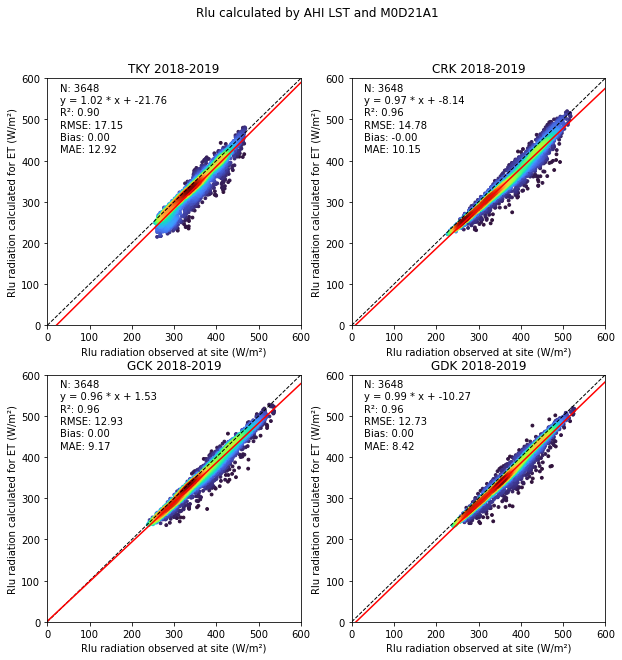

In [10]:
site_names = ['TKY','CRK', 'GCK', 'GDK']

SITE_TKY_CSV = '/disk2/Data/FluxSite4ET/validation/TKY_2018.csv'
tky_csv_data = numpy.genfromtxt(SITE_TKY_CSV, delimiter=',', dtype=str)
tky_site_obs_10min = half_hour_to_10min_by_nan_2y(tky_csv_data[:,6][1:].astype(float))

SITE_CRK_CSV = '/disk2/Data/FluxSite4ET/validation/CRK_2018_2019_L2.csv'
crk_csv_data = numpy.genfromtxt(SITE_CRK_CSV, delimiter=',', dtype=str)
crk_site_obs_10min = half_hour_to_10min_by_nan(crk_csv_data[:,4][1:].astype(float))

SITE_GCK_CSV = '/disk2/Data/FluxSite4ET/validation/GCK_2018_2019_L2.csv'
gck_csv_data = numpy.genfromtxt(SITE_GCK_CSV, delimiter=',', dtype=str)
gck_site_obs_10min = half_hour_to_10min_by_nan(gck_csv_data[:,4][1:].astype(float))

SITE_GDK_CSV = '/disk2/Data/FluxSite4ET/validation/GDK_2018_2019_L2.csv'
gdk_csv_data = numpy.genfromtxt(SITE_GDK_CSV, delimiter=',', dtype=str)
gdk_site_obs_10min = half_hour_to_10min_by_nan(gdk_csv_data[:,4][1:].astype(float))

site_obs=[tky_site_obs_10min, crk_site_obs_10min, gck_site_obs_10min, gdk_site_obs_10min]

site_cal = []
for d_idx in range(len(site_names)):
    site_name = site_names[d_idx]
    SITE_CAL_CSV = '/disk2/Data/FluxSite4ET/'+site_name+'_RluV002.csv'
    cal_timelist, site_cal_item = read_site_csv(SITE_CAL_CSV)
    site_cal.append(site_cal_item)
    
mapping_rlu_comparison(site_obs, site_cal, 'Rlu calculated by AHI LST and M0D21A1')